In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('/content/AAPL (1).csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-07-06,23.650000,23.915001,23.592501,23.882500,22.052250,123796400
1,2016-07-07,23.924999,24.125000,23.905001,23.985001,22.146896,100558400
2,2016-07-08,24.122499,24.222500,24.012501,24.170000,22.317717,115648400
3,2016-07-11,24.187500,24.412500,24.182501,24.245001,22.386972,95179600
4,2016-07-12,24.292500,24.424999,24.280001,24.355000,22.488541,96670000
...,...,...,...,...,...,...,...
1756,2023-06-28,187.929993,189.899994,187.600006,189.250000,189.250000,51216800
1757,2023-06-29,189.080002,190.070007,188.940002,189.589996,189.589996,46347300
1758,2023-06-30,191.630005,194.479996,191.259995,193.970001,193.970001,85069600
1759,2023-07-03,193.779999,193.880005,191.759995,192.460007,192.460007,31458200


In [4]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2016-07-06,23.882500
1,2016-07-07,23.985001
2,2016-07-08,24.170000
3,2016-07-11,24.245001
4,2016-07-12,24.355000
...,...,...
1756,2023-06-28,189.250000
1757,2023-06-29,189.589996
1758,2023-06-30,193.970001
1759,2023-07-03,192.460007


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

<ipython-input-6-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


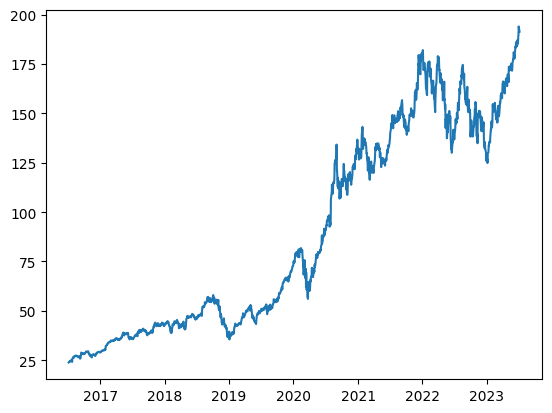

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [57]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2016-07-15,24.695000,24.697500,24.217501,24.355000,24.245001,24.170000,23.985001,23.882500
2016-07-18,24.957500,24.695000,24.697500,24.217501,24.355000,24.245001,24.170000,23.985001
2016-07-19,24.967501,24.957500,24.695000,24.697500,24.217501,24.355000,24.245001,24.170000
2016-07-20,24.990000,24.967501,24.957500,24.695000,24.697500,24.217501,24.355000,24.245001
2016-07-21,24.857500,24.990000,24.967501,24.957500,24.695000,24.697500,24.217501,24.355000
...,...,...,...,...,...,...,...,...
2023-06-28,189.250000,188.059998,185.270004,186.679993,187.000000,183.960007,185.009995,184.919998
2023-06-29,189.589996,189.250000,188.059998,185.270004,186.679993,187.000000,183.960007,185.009995
2023-06-30,193.970001,189.589996,189.250000,188.059998,185.270004,186.679993,187.000000,183.960007


In [58]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 24.695   ,  24.6975  ,  24.217501, ...,  24.17    ,  23.985001,
         23.8825  ],
       [ 24.9575  ,  24.695   ,  24.6975  , ...,  24.245001,  24.17    ,
         23.985001],
       [ 24.967501,  24.9575  ,  24.695   , ...,  24.355   ,  24.245001,
         24.17    ],
       ...,
       [193.970001, 189.589996, 189.25    , ..., 186.679993, 187.      ,
        183.960007],
       [192.460007, 193.970001, 189.589996, ..., 185.270004, 186.679993,
        187.      ],
       [191.330002, 192.460007, 193.970001, ..., 188.059998, 185.270004,
        186.679993]])

In [59]:
shifted_df_as_np.shape

(1754, 8)

In [60]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.9937869 , -0.99375745, -0.99941107, ..., -0.99996949,
        -1.        , -1.        ],
       [-0.99069507, -0.9937869 , -0.99375745, ..., -0.99905425,
        -0.99773028, -0.99874322],
       [-0.99057728, -0.99069507, -0.9937869 , ..., -0.99771191,
        -0.99681011, -0.99647493],
       ...,
       [ 1.        ,  0.94841059,  0.94440599, ...,  0.98315963,
         1.        ,  0.96272634],
       [ 0.9822147 ,  1.        ,  0.94841059, ...,  0.96595337,
         0.9960739 ,  1.        ],
       [ 0.96890506,  0.9822147 ,  1.        , ...,  1.        ,
         0.97877501,  0.99607636]])

In [61]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1754, 7), (1754,))

In [62]:
X = dc(np.flip(X, axis=1))
X

array([[-1.        , -1.        , -0.99996949, ..., -0.99773308,
        -0.99941107, -0.99375745],
       [-0.99874322, -0.99773028, -0.99905425, ..., -0.99939548,
        -0.99375745, -0.9937869 ],
       [-0.99647493, -0.99681011, -0.99771191, ..., -0.99359217,
        -0.9937869 , -0.99069507],
       ...,
       [ 0.96272634,  1.        ,  0.98315963, ...,  0.98150194,
         0.94440599,  0.94841059],
       [ 1.        ,  0.9960739 ,  0.96595337, ...,  0.99588936,
         0.94841059,  1.        ],
       [ 0.99607636,  0.97877501,  1.        , ...,  1.        ,
         1.        ,  0.9822147 ]])

In [63]:
split_index = int(len(X) * 0.95)

split_index

1666

In [64]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1666, 7), (88, 7), (1666,), (88,))

In [65]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1666, 7, 1), (88, 7, 1), (1666, 1), (88, 1))

In [66]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1666, 7, 1]),
 torch.Size([88, 7, 1]),
 torch.Size([1666, 1]),
 torch.Size([88, 1]))

In [67]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [68]:
train_dataset

In [69]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [82]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [83]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [84]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [85]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [86]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.286

Val Loss: 0.613
***************************************************

Epoch: 2
Batch 100, Loss: 0.115

Val Loss: 0.270
***************************************************

Epoch: 3
Batch 100, Loss: 0.022

Val Loss: 0.146
***************************************************

Epoch: 4
Batch 100, Loss: 0.014

Val Loss: 0.108
***************************************************

Epoch: 5
Batch 100, Loss: 0.011

Val Loss: 0.089
***************************************************

Epoch: 6
Batch 100, Loss: 0.008

Val Loss: 0.072
***************************************************

Epoch: 7
Batch 100, Loss: 0.006

Val Loss: 0.055
***************************************************

Epoch: 8
Batch 100, Loss: 0.004

Val Loss: 0.042
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.034
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.027
********************************

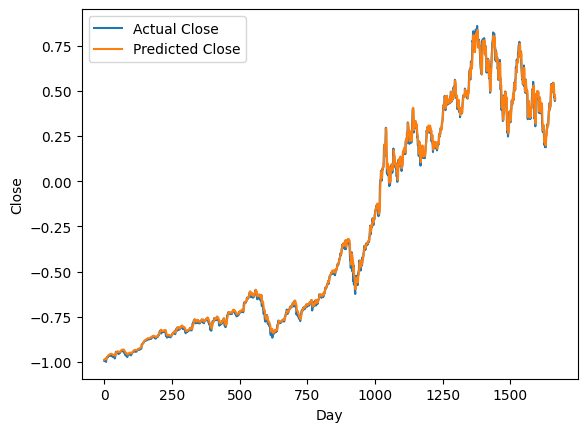

In [87]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [88]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 25.22811181,  25.34260077,  25.50293793, ..., 149.00244563,
       149.51931336, 147.41283858])

In [89]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 24.69500238,  24.9575011 ,  24.96750067, ..., 149.39999415,
       146.71000728, 147.91999772])

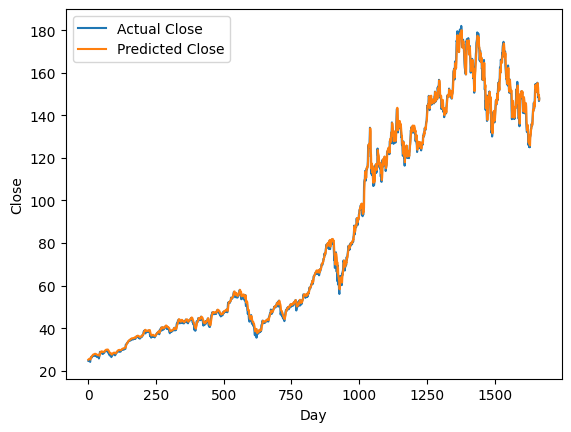

In [90]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [91]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([147.96585605, 147.75518707, 145.93544579, 146.07885555,
       150.44605194, 153.63599431, 152.27738937, 152.86228299,
       151.15571746, 149.03974411, 150.32270203, 152.43658286,
       153.14966929, 155.53603828, 155.31506104, 157.10358151,
       159.00457685, 158.17914713, 158.79516287, 160.01182054,
       158.67481385, 157.81757377, 160.18487982, 162.00252352,
       164.32100578, 165.772299  , 165.60663312, 164.03877108,
       164.36541175, 162.41756622, 160.98315485, 160.17386309,
       164.36364563, 165.07624119, 165.12374925, 166.06169432,
       167.16363531, 166.63601148, 165.20044126, 165.11324363,
       163.91619544, 163.63751321, 167.22288375, 169.04299698,
       169.31701341, 168.52087898, 167.46416375, 165.93466037,
       171.49697943, 172.8422398 , 171.77832348, 172.77907959,
       173.1832928 , 172.38519995, 171.78750324, 171.65432077,
       172.09616392, 173.94723228, 174.49981961, 173.9068646 ,
       171.77635494, 171.43579281, 172.2518859 , 174.26

In [92]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([147.4100047 , 145.30999725, 145.91000408, 151.02999924,
       153.8300041 , 151.60000484, 152.86999521, 150.58999558,
       148.50000036, 150.4700008 , 152.58999725, 152.99000517,
       155.85000743, 154.99999882, 157.39999576, 159.28000011,
       157.83000238, 158.92999507, 160.24999845, 158.27999801,
       157.64999502, 160.77000622, 162.36000293, 164.89999378,
       166.16999933, 165.63000255, 163.75999271, 164.66000421,
       162.02999702, 160.80000492, 160.10000496, 165.55999547,
       165.21000562, 165.22999463, 166.47000148, 167.63000675,
       166.64999366, 165.02000375, 165.33000041, 163.77000239,
       163.75999271, 168.41000323, 169.67999359, 169.5899975 ,
       168.53999252, 167.44999939, 165.78999054, 173.57000677,
       173.49999969, 171.770004  , 173.55999708, 173.74999895,
       172.57000467, 172.07000615, 172.07000615, 172.69000452,
       175.05000319, 175.16000348, 174.19999458, 171.55999794,
       171.8399959 , 172.99000666, 175.42999175, 177.30

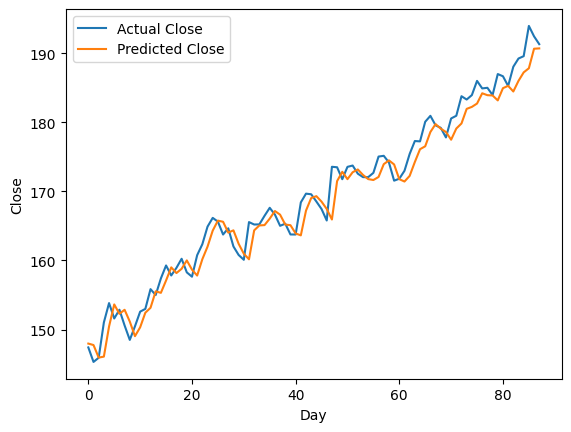

In [93]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
